# AB test ÌÜµÍ≥Ñ Í≤ÄÏ†ï ÏΩîÎìú 
## abtest_auto() -> Ïù¥ Ìï®ÏàòÎäî AB test group ÏàòÏóê Îî∞Î•∏ ÌÜµÍ≥Ñ Í≤ÄÏ†ï Î∞©Ïãù ÏûêÎèô ÎåÄÏùë

1. AB test group 2 Í∞úÏù∏ Í≤ΩÏö∞ -> Z-test, chi-square, bayesian
2. AB test group 3 Í∞úÏù∏ Í≤ΩÏö∞ -> Z-test(Îã§Ï§ëÎ≥¥Ï†ï), chi-square, bayesian

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# ‚úÖ Ï†ÑÏ≤¥ float Ï∂úÎ†• Ìè¨Îß∑ ÏÜåÏàòÏ†ê 4ÏûêÎ¶¨Î°ú Í≥†Ï†ï (ÌòÑÏû¨ ÏÑ∏ÏÖòÏóêÎßå Ï†ÅÏö©. python Îã§Ïãú ÏãúÏûëÌïòÎ©¥ Îã§Ïãú ÏÑ§Ï†ïÌï¥Ï§òÏïº Ìï®.)
pd.set_option('display.float_format', '{:.4f}'.format)

def abtest_auto(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    print("\n" + "#"*70)
    print(f"üìä {metric_name}\n" + "#"*70)

    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n‚úÖ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    if len(groups) == 2:
        # ‚úÖ Z-test (2Í∞ú Í∑∏Î£π)
        count = np.array([successes[0], successes[1]])
        nobs = np.array([trials[0], trials[1]])
        zstat, pval = proportions_ztest(count, nobs)
        print("\n‚úÖ Z-test (2 groups)")
        print(f"- Z statistic: {zstat:.4f}")
        print(f"- p-value: {pval:.4f}")
        print(f"\n{'='*60}")

        # ‚úÖ Chi-square test (2x2 contingency table)
        contingency = np.array([
            [successes[0], failures[0]],
            [successes[1], failures[1]]
        ])
        chi2, chi_p, _, _ = chi2_contingency(contingency)
        print("\n‚úÖ Chi-square Test (2x2)")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {chi_p:.4f}")
        print(f"\n{'='*60}")

    else:
        # ‚úÖ Chi-square test (3Í∞ú Ïù¥ÏÉÅ)
        contingency_table = np.array([successes, failures]).T
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print("\n‚úÖ Chi-square Test")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {p_value:.4f}")
        print(f"\n{'='*60}")

        # ‚úÖ ÏÇ¨ÌõÑ Pairwise Z-test (Holm-Bonferroni Î≥¥Ï†ï, ÎπàÎèÑÏ£ºÏùò Î≥¥ÏàòÏ†Å Î∞©Ïãù)
        pairwise_results, pairs = [], []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                count = np.array([successes[i], successes[j]])
                nobs = np.array([trials[i], trials[j]])
                _, p = proportions_ztest(count, nobs)
                pairwise_results.append(p)
                pairs.append(f"{groups[i]} vs {groups[j]}")

        reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
        results_df = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (Holm)': pvals_corrected,
            'Significant': reject
        })
        print("\n‚úÖ Pairwise Z-test (Holm-Bonferroni):")
        display(results_df)
        print(f"\n{'='*60}")


        # ‚úÖ ÏÇ¨ÌõÑ Pairwise Z-test (FDR Î≥¥Ï†ï, ÎπàÎèÑÏ£ºÏùò Ïú†Ïó∞Ìïú Î∞©Ïãù)
        reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
        results_df_fdr = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (FDR)': pvals_fdr_corrected,
            'Significant (FDR)': reject_fdr
        })
        print("\n‚úÖ Pairwise Z-test (FDR - Benjamini-Hochberg):")
        display(results_df_fdr)
        print(f"\n{'='*60}")

    # ‚úÖ Bayesian analysis (Í≥µÌÜµ)
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)
        for group, success, fail in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")

    # ‚úÖ Í∞Å Í∑∏Î£πÏù¥ bestÏùº ÌôïÎ•†
    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n‚úÖ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # ‚úÖ ÏåçÎ≥Ñ Ïö∞ÏúÑ ÌôïÎ•†
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n‚úÖ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")



# ‚úÖ ÏïÑÎûòÏôÄ Í∞ôÏù¥ ÏÑ∏ÌåÖÌïòÏó¨ ÏÇ¨Ïö©ÌïòÎ©¥ Îê® ‚úÖ
# groups = ['A', 'B']
# TOTAL_PCID = np.array([385312, 42586])
# SELL_HOME = np.array([32007, 40703])
# abtest_auto(groups, SELL_HOME, TOTAL_PCID, metric_name="Total PCID to Sell Home CVR")


# 2-1. Ïã§Ìóò Í≤∞Í≥º ÌÜµÍ≥Ñ Í≤ÄÏ†ï
Ïã§Ìóò Ï∞∏Ïó¨Ïûê Ï†ÑÏ≤¥Î•º Î™®ÏàòÎ°ú Í∞Å Ïï°ÏÖòÎ≥Ñ Ï†ÑÌôòÏú® ÏßÄÌëú Í≥ÑÏÇ∞


######################################################################
üìä Total PCID to Sell Home CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A      32007  385312           8.31%
1     B      40703   42586          95.58%



‚úÖ Z-test (2 groups)
- Z statistic: -455.0472
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 207061.7857
- p-value: 0.0000



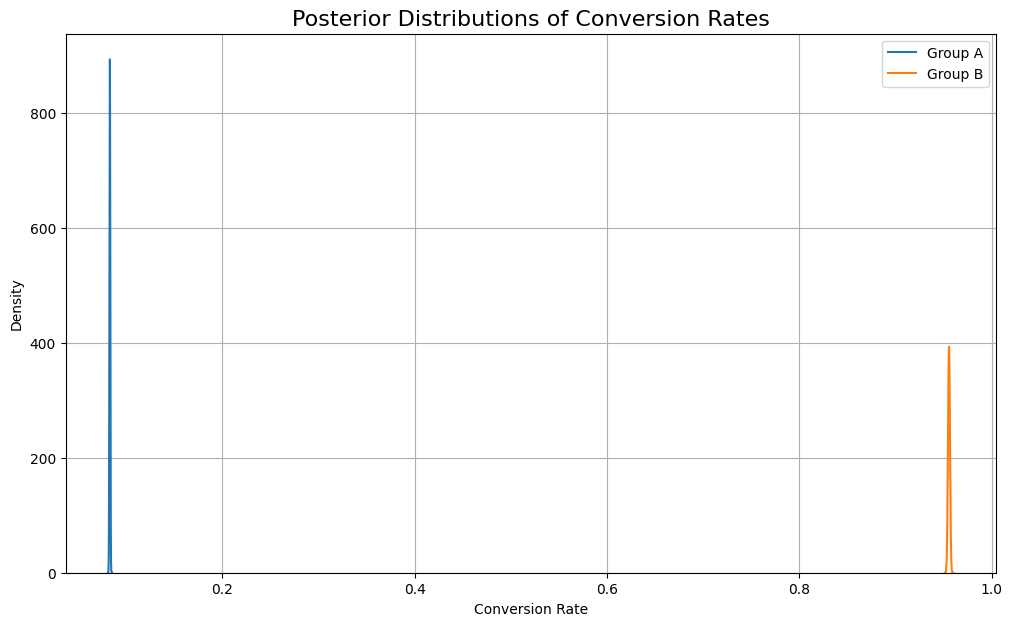



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.0000              1.0000



######################################################################
üìä Total PCID to Check Owner CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       8339  385312           2.16%
1     B       2240   42586           5.26%



‚úÖ Z-test (2 groups)
- Z statistic: -39.0405
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 1522.8795
- p-value: 0.0000



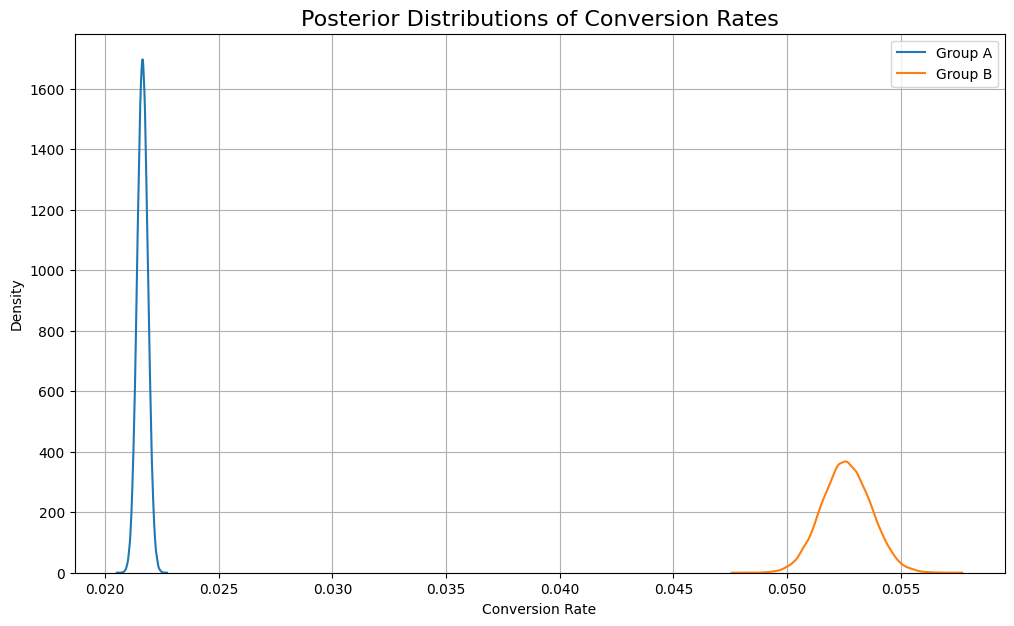



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.0000              1.0000



######################################################################
üìä Total PCID to Try MyGarage CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       7152  385312           1.86%
1     B       1711   42586           4.02%



‚úÖ Z-test (2 groups)
- Z statistic: -29.7213
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 882.2930
- p-value: 0.0000



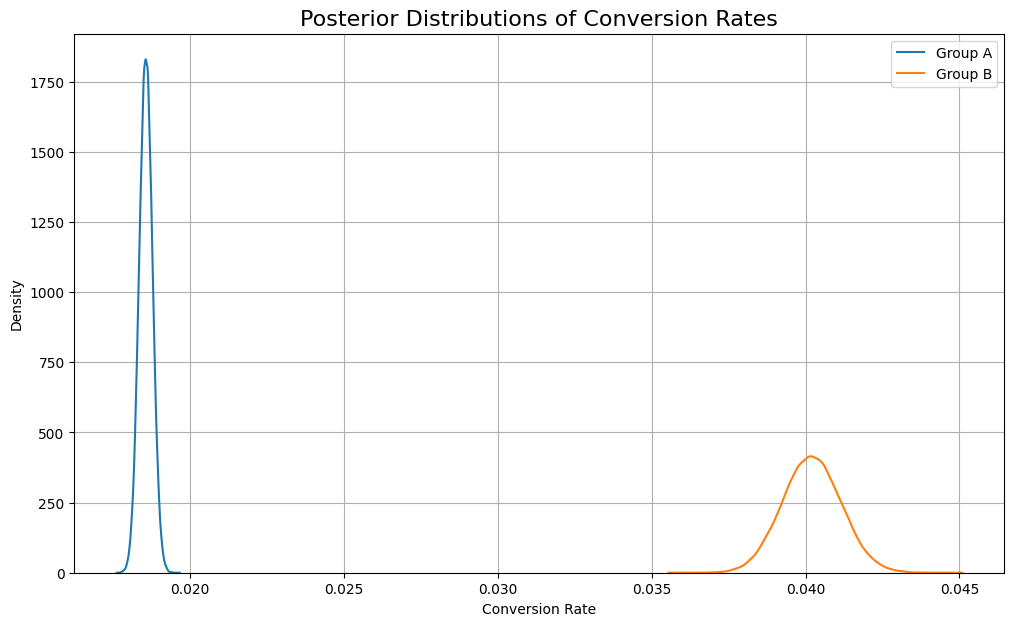



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.0000              1.0000



######################################################################
üìä Total PCID to MyCar Home CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       6582  385312           1.71%
1     B       1535   42586           3.60%



‚úÖ Z-test (2 groups)
- Z statistic: -27.2204
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 739.9335
- p-value: 0.0000



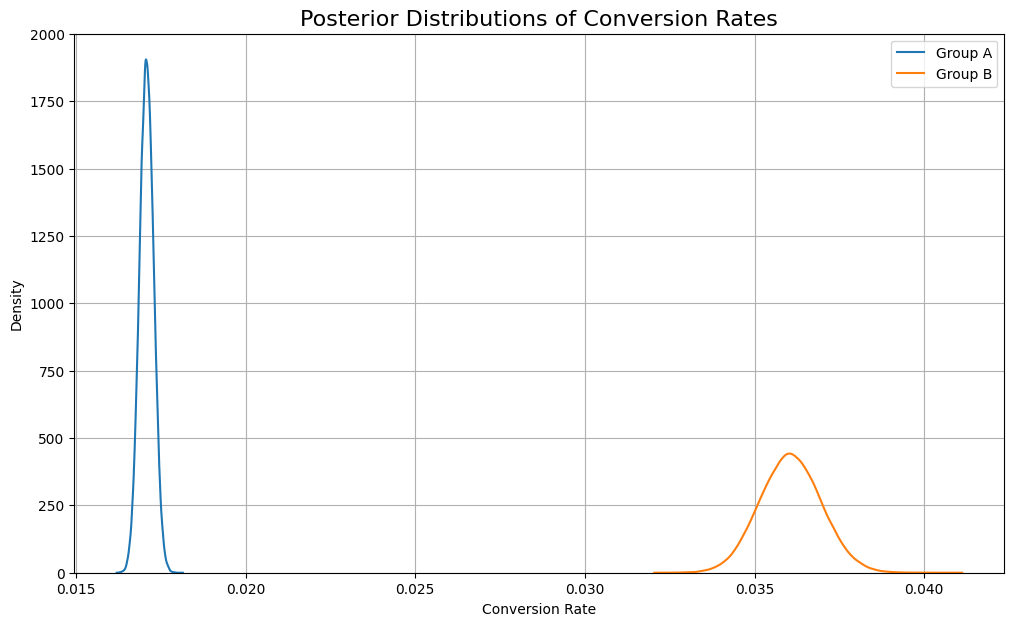



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.0000              1.0000



######################################################################
üìä Total PCID to Request a Estimate Complete CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A        631  385312           0.16%
1     B         71   42586           0.17%



‚úÖ Z-test (2 groups)
- Z statistic: -0.1431
- p-value: 0.8862


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 0.0064
- p-value: 0.9362



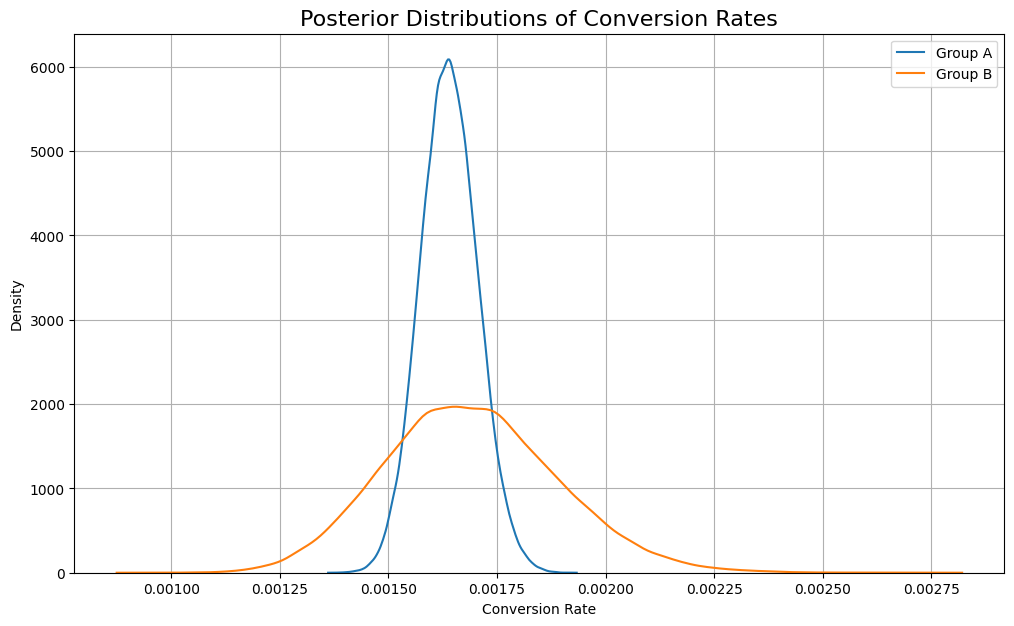



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 41.80%
Probability that B is the best: 58.20%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.4180              0.5820



######################################################################
üìä Total PCID to Buy Home CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A     309623  385312          80.36%
1     B      32054   42586          75.27%



‚úÖ Z-test (2 groups)
- Z statistic: 24.8374
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 616.5796
- p-value: 0.0000



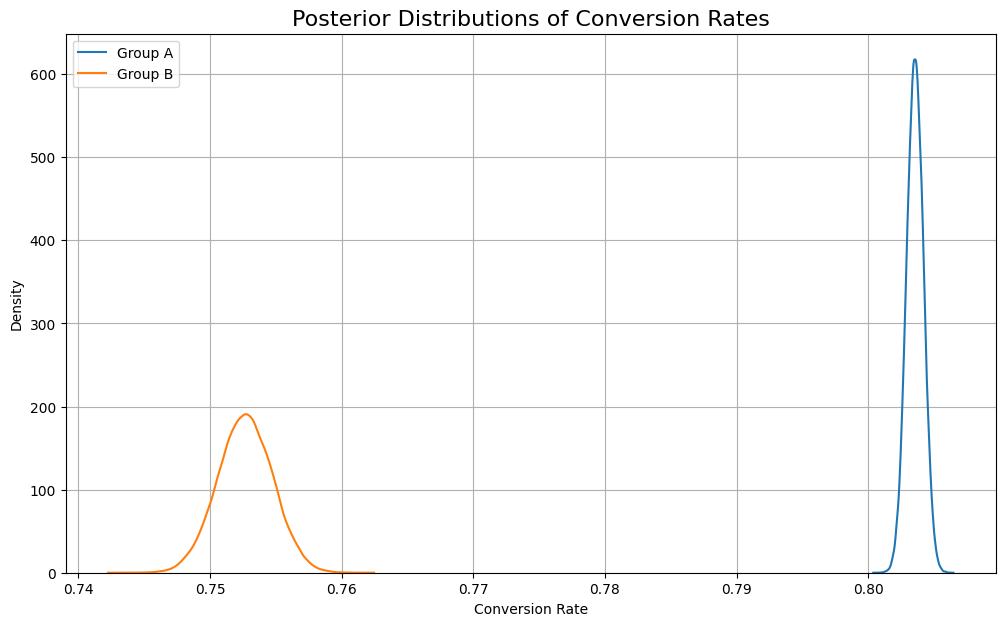



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              1.0000              0.0000



######################################################################
üìä Total PCID to Search Home CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A     336439  385312          87.32%
1     B      35679   42586          83.78%



‚úÖ Z-test (2 groups)
- Z statistic: 20.5595
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 422.3804
- p-value: 0.0000



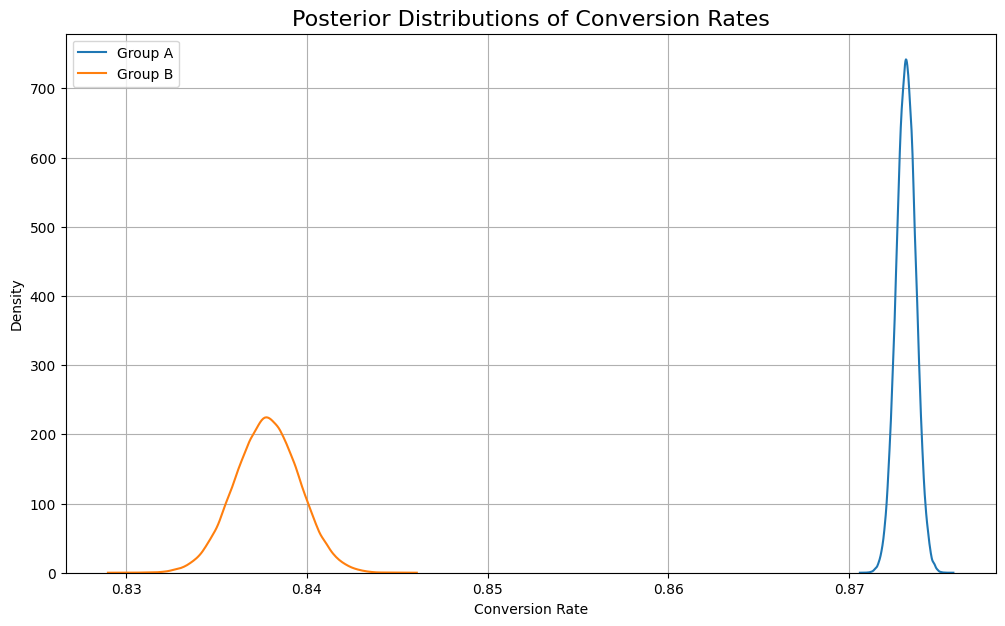



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              1.0000              0.0000



######################################################################
üìä Total PCID to Car Detail CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A     283457  385312          73.57%
1     B      30606   42586          71.87%



‚úÖ Z-test (2 groups)
- Z statistic: 7.5200
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 56.4633
- p-value: 0.0000



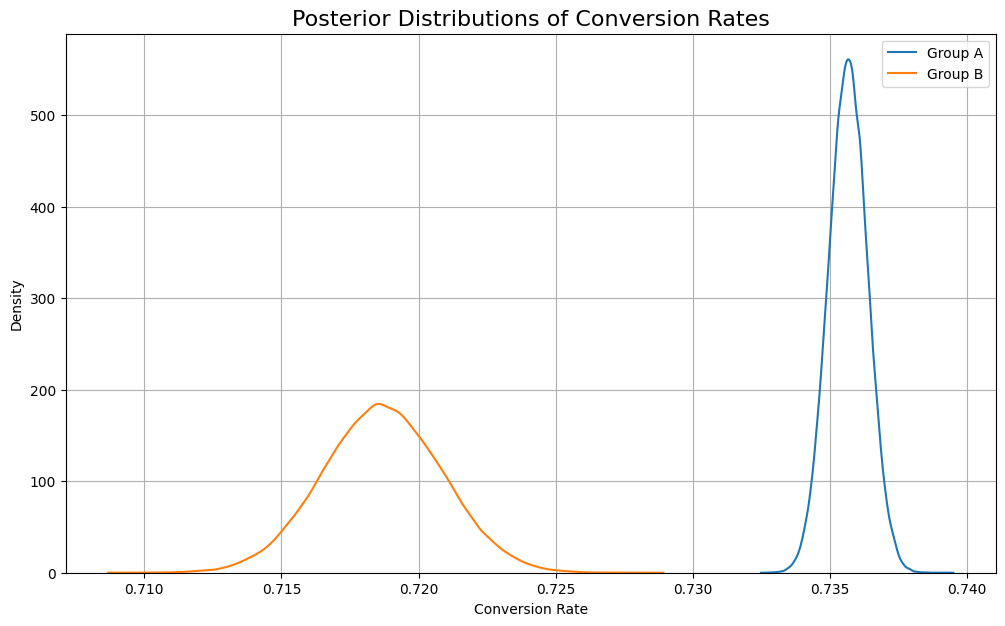



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              1.0000              0.0000



######################################################################
üìä Total PCID to Contact Click CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       6711  385312           1.74%
1     B        725   42586           1.70%



‚úÖ Z-test (2 groups)
- Z statistic: 0.5885
- p-value: 0.5562


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 0.3237
- p-value: 0.5694



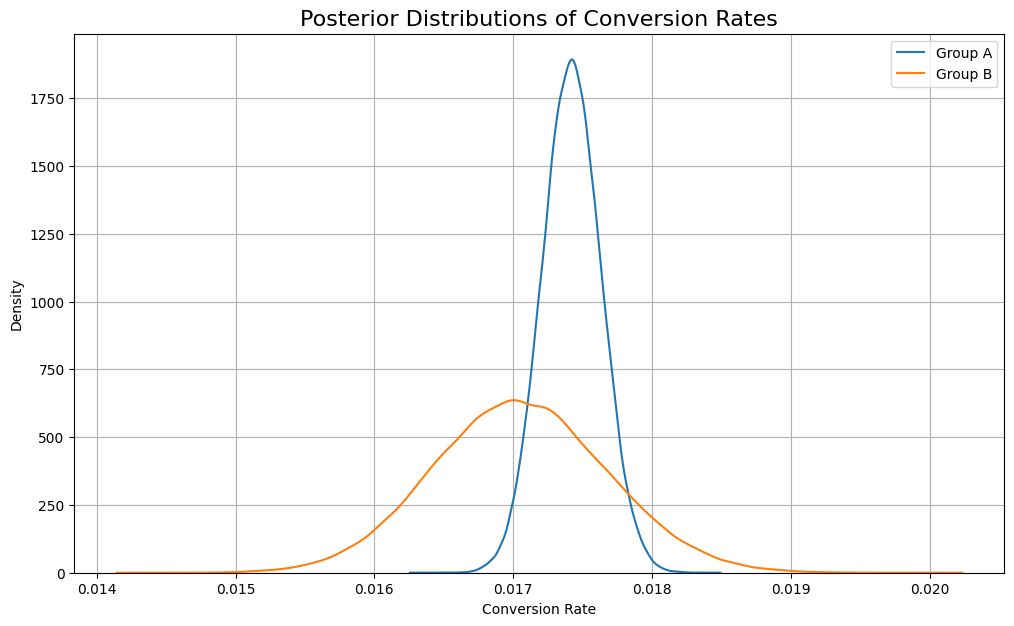



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 71.31%
Probability that B is the best: 28.69%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.7131              0.2869

In [4]:
# Test group ÏûëÏÑ±
groups = ['A', 'B']

# Í∞Å Ïù¥Î≤§Ìä∏ Î≥Ñ Ïã§Ìóò Í≤∞Í≥º Ï†ïÎ¶¨
TOTAL_PCID = np.array([385312, 42586])
TOTAL_EVENT = np.array([277322522, 30418540])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# AB test 3Í∑∏Î£π Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞ abtest_multi() ÏÇ¨Ïö©
# abtest_multi(groups, successes, trials, metric_name="")
# Metric Î≥Ñ ÏûëÏÑ±

# ÎÇ¥Ï∞®ÌåîÍ∏∞ metric
# 0. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> ÎÇ¥Ï∞®ÌåîÍ∏∞ Ìôà ÏßÑÏûÖ CVR
abtest_auto(groups, SELL_HOME, TOTAL_PCID, metric_name="Total PCID to Sell Home CVR")
# 1. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> ÏÜåÏú†ÏûêÎ™Ö ÌôïÏù∏ ÌéòÏù¥ÏßÄ CVR
abtest_auto(groups, CHECK_OWNER, TOTAL_PCID, metric_name="Total PCID to Check Owner CVR")
# 2. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> Ï∞®ÎüâÏ†ïÎ≥¥ÌôïÏù∏Ï§ë (ÎÇ¥Ï∞®Í≥†Îì±Î°ùÏãúÎèÑ) CVR
abtest_auto(groups, TRY_MYGARAGE, TOTAL_PCID, metric_name="Total PCID to Try MyGarage CVR")
# 3. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> ÎÇ¥Ï∞®Í≥† Ìôà CVR
abtest_auto(groups, MYCAR_HOME_ING, TOTAL_PCID, metric_name="Total PCID to MyCar Home CVR")
# 4. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> ÎπÑÍµêÍ≤¨Ï†Å Ïã†Ï≤≠ ÏôÑÎ£å CVR
abtest_auto(groups, ESTIMATE_COMPLETE, TOTAL_PCID, metric_name="Total PCID to Request a Estimate Complete CVR")

# ÎÇ¥Ï∞®ÏÇ¨Í∏∞ metric
# 5. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> ÎÇ¥Ï∞®ÏÇ¨Í∏∞ Ìôà CVR
abtest_auto(groups, BUY_HOME, TOTAL_PCID, metric_name="Total PCID to Buy Home CVR")
# 6. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> Í≤ÄÏÉâ Ìôà CVR
abtest_auto(groups, SEARCH_HOME, TOTAL_PCID, metric_name="Total PCID to Search Home CVR")
# 7. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> Ï∞®ÎüâÏÉÅÏÑ∏ CVR
abtest_auto(groups, CAR_DETAIL, TOTAL_PCID, metric_name="Total PCID to Car Detail CVR")
# 8. Ïã§ÌóòÏ∞∏Ïó¨Ïûê Ï†ÑÏ≤¥ -> Î¨∏ÏùòÌïòÍ∏∞ ÌÅ¥Î¶≠ CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, TOTAL_PCID, metric_name="Total PCID to Contact Click CVR")

# 2-3. Ï†Ñ Funnel Ïùò Ï†ÑÌôòÏú® ÏßÄÌëú Í≥ÑÏÇ∞


######################################################################
üìä Check car number to Check Owner CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       8339   32007          26.05%
1     B       2240   40703           5.50%



‚úÖ Z-test (2 groups)
- Z statistic: 78.0147
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 6084.6416
- p-value: 0.0000



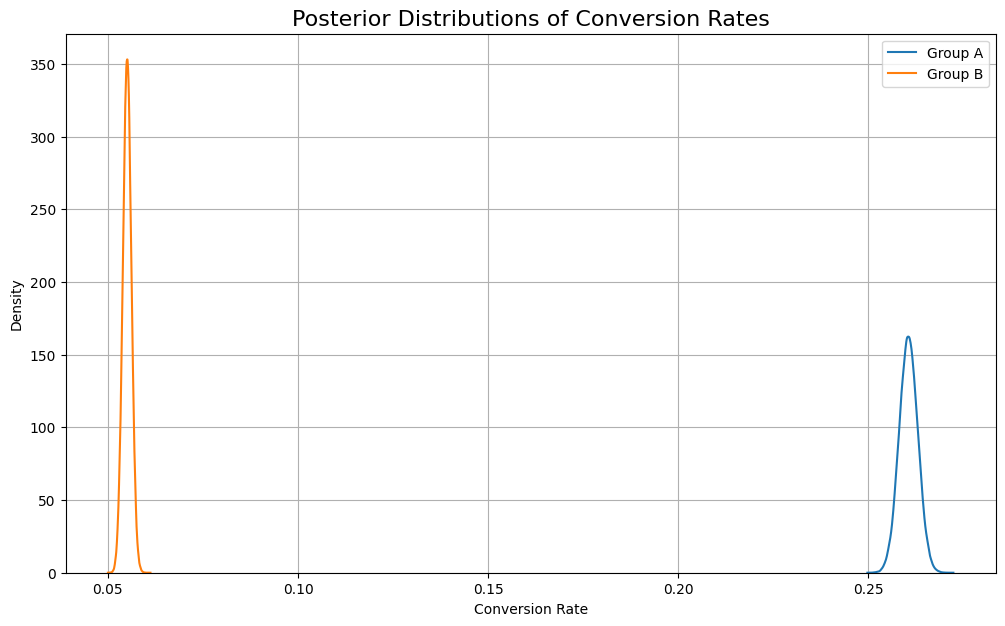



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              1.0000              0.0000



######################################################################
üìä MY GARAGE to Request a Estimate Complete CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A        631    6582           9.59%
1     B         71    1535           4.63%



‚úÖ Z-test (2 groups)
- Z statistic: 6.2274
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 38.1550
- p-value: 0.0000



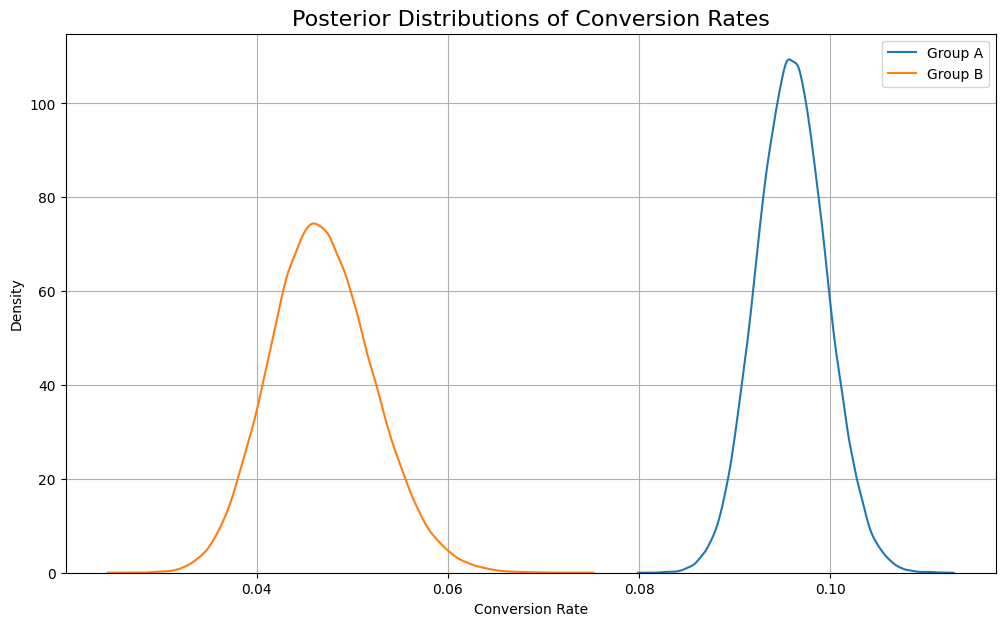



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              1.0000              0.0000



######################################################################
üìä Buy Home to Car Detail CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A     283457  309623          91.55%
1     B      30606   32054          95.48%



‚úÖ Z-test (2 groups)
- Z statistic: -24.5967
- p-value: 0.0000


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 604.4680
- p-value: 0.0000



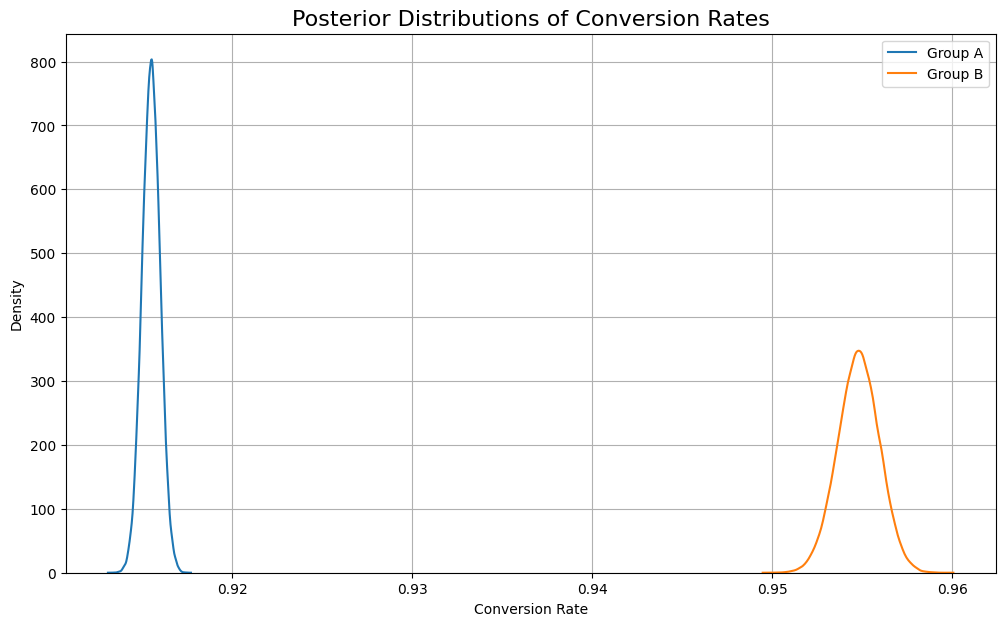



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.0000              1.0000



######################################################################
üìä Car Detail to Contact Click CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       6711  283457           2.37%
1     B        725   30606           2.37%



‚úÖ Z-test (2 groups)
- Z statistic: -0.0138
- p-value: 0.9890


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 0.0000
- p-value: 1.0000



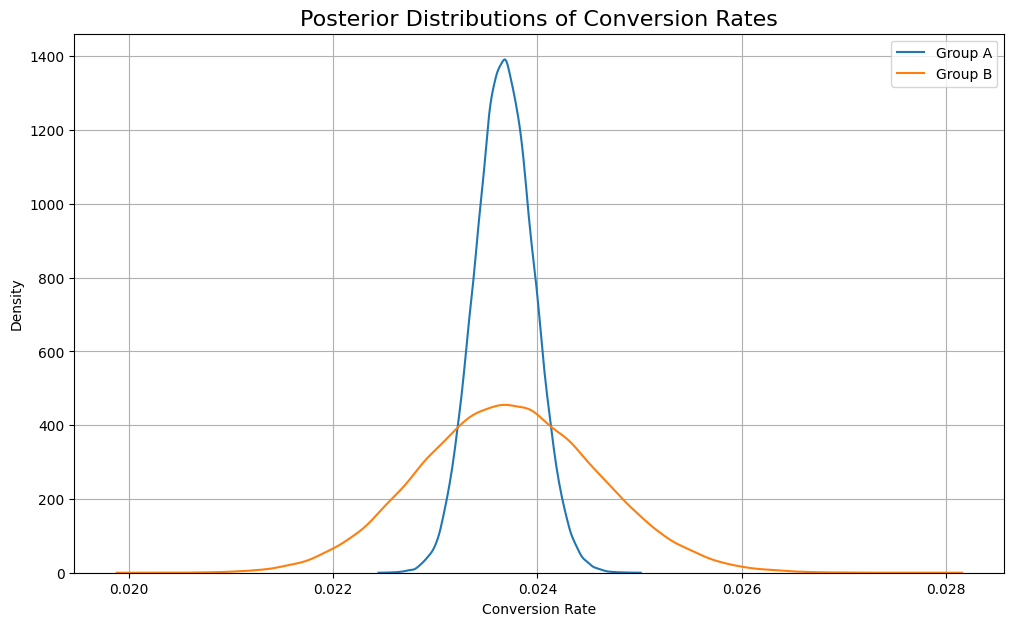



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 48.65%
Probability that B is the best: 51.35%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.4865              0.5135



######################################################################
üìä Buy Home to Contact Click CVR
######################################################################

‚úÖ Group Summary (Successes, Trials, Conversion Rate)


Group  Successes  Trials Conversion Rate
0     A       6711  309623           2.17%
1     B        725   32054           2.26%



‚úÖ Z-test (2 groups)
- Z statistic: -1.1019
- p-value: 0.2705


‚úÖ Chi-square Test (2x2)
- Chi2 statistic: 1.1702
- p-value: 0.2794



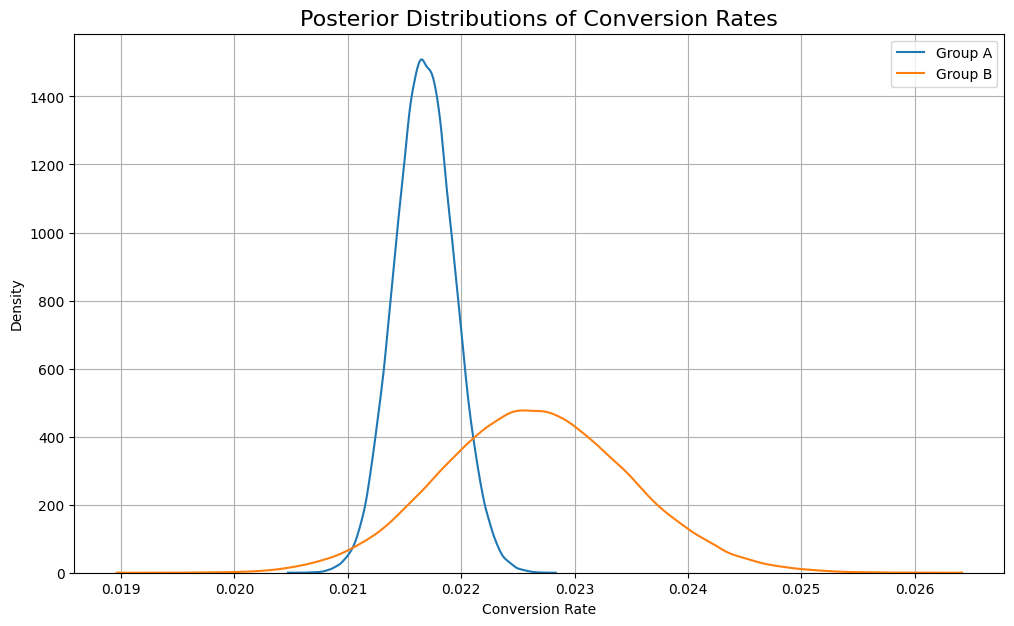



‚úÖ Bayesian: Probability that each group is best
Probability that A is the best: 13.13%
Probability that B is the best: 86.87%


‚úÖ Bayesian Pairwise Superiority Probabilities:


Comparison  P(Group1 > Group2)  P(Group1 < Group2)
0      A > B              0.1313              0.8687

In [5]:
# Test group ÏûëÏÑ±
groups = ['A', 'B']

# Í∞Å Ïù¥Î≤§Ìä∏ Î≥Ñ Ïã§Ìóò Í≤∞Í≥º Ï†ïÎ¶¨
TOTAL_PCID = np.array([385312, 42586])
TOTAL_EVENT = np.array([277322522, 30418540])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# AB test 3Í∑∏Î£π Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞ abtest_multi() ÏÇ¨Ïö©
# abtest_multi(groups, successes, trials, metric_name="")
# Metric Î≥Ñ ÏûëÏÑ±

# ÎÇ¥Ï∞®ÏÇ¨Í∏∞ metric
# 1. Î≤àÌò∏Ìåê Ï°∞Ìöå -> ÏÜåÏú†ÏûêÎ™Ö CVR
abtest_auto(groups, CHECK_OWNER, SELL_HOME, metric_name="Check car number to Check Owner CVR")
# 2. ÎÇ¥Ï∞®Í≥† Ìôà -> ÎπÑÍµêÍ≤¨Ï†Å Ïã†Ï≤≠ ÏôÑÎ£å CVR
abtest_auto(groups, ESTIMATE_COMPLETE, MYCAR_HOME_ING, metric_name="MY GARAGE to Request a Estimate Complete CVR")

# ÎÇ¥Ï∞®ÏÇ¨Í∏∞ metric
# 3. ÎÇ¥Ï∞®ÏÇ¨Í∏∞ Ìôà -> Ï∞®ÎüâÏÉÅÏÑ∏ CVR
abtest_auto(groups, CAR_DETAIL, BUY_HOME, metric_name="Buy Home to Car Detail CVR")
# 4. Ï∞®ÎüâÏÉÅÏÑ∏ -> Î¨∏ÏùòÌïòÍ∏∞ ÌÅ¥Î¶≠ CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, CAR_DETAIL, metric_name="Car Detail to Contact Click CVR")
# 5. ÎÇ¥Ï∞®ÏÇ¨Í∏∞ Ìôà -> Î¨∏ÏùòÌïòÍ∏∞ ÌÅ¥Î¶≠ CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, BUY_HOME, metric_name="Buy Home to Contact Click CVR")